In [21]:
%%writefile cfg.py
import argparse
import os

def get_config():
    parser = argparse.ArgumentParser()

    # Model
    parser.add_argument('--txt_file', type=str, default="./assets/book_EN_grimms_fairy_tales.txt")
    parser.add_argument('--model_type', type=str, default='gpt-mini')
    parser.add_argument('--block_size', type=int, default=128)
    parser.add_argument('--use_pretrained', type=bool, default=False)
    parser.add_argument('--abs_emb', action="store_true")

    # Training
    parser.add_argument('--train_batch_size', type=int, default=128)
    parser.add_argument('--generate_batch_size', type=int, default=5)
    parser.add_argument('--generate_every_n_steps', type=int, default=1000)
    parser.add_argument('--learning_rate', type=float, default=5e-4)
    parser.add_argument('--weight_decay', type=float, default=0.1)
    parser.add_argument('--betas', type=tuple, default=(0.9, 0.95))
    parser.add_argument('--num_epochs', type=int, default=5)  # ← as assignment asks
    parser.add_argument('--clip_grad_norm', type=float, default=1.0)

    # Logging / misc
    parser.add_argument('--log_dir', type=str, default='./logs_snellius')
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--num_workers', type=int, default=2)
    parser.add_argument('--progress_bar', action='store_true')
    parser.add_argument("--use_flash_attn", action="store_true")
    parser.add_argument("--precision", choices={"bf16", "bf16-mixed", "16-mixed", "16", "32"}, default="16-mixed")
    parser.add_argument("--compile", action="store_true")
    parser.add_argument("--pretrained_tokenizer", action="store_true")
    args, _ = parser.parse_known_args()
    return args


Overwriting cfg.py


In [22]:
%%writefile dataset.py
from argparse import Namespace
from typing import Any
import torch
from torch.utils.data import Dataset

class CharTokenizer:
    def __init__(self, datafile_path: str, return_tensors: bool = False):
        with open(datafile_path, 'r') as file:
            data = file.read()
        chars = sorted(set(data))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))

        self.vocab_size = vocab_size
        self.string_to_index = { ch:i for i,ch in enumerate(chars) }
        self.index_to_string = { i:ch for i,ch in enumerate(chars) }
        self.return_tensors = return_tensors

    def encode(self, string: str):
        if self.return_tensors:
            out = torch.tensor([self.string_to_index[ch] for ch in string], dtype=torch.long)
        else:
            out = [self.string_to_index[ch] for ch in string]
        return out

    def decode(self, indices):
        if isinstance(indices, torch.Tensor):
            indices = indices.tolist()
        return ''.join([self.index_to_string[i] for i in indices])

class TextDataset(Dataset):
    def __init__(self, config: Namespace, datafile_path: str, block_size:int = 128, tokenizer: Any = None):
        self.config = config
        with open(datafile_path, 'r') as file:
            data = file.read()
        self.tokenizer = tokenizer
        self.data = self.tokenizer.encode(data)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        dix = self.data[idx:idx + 1 + self.block_size]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y


Overwriting dataset.py


In [23]:
%%writefile gpt.py

"""
Full definition of a GPT Language Model, all of it in this single file.

References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
from argparse import Namespace

import torch
import torch.nn as nn
from torch.nn import functional as F
from typing import Tuple



class BERTGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class RMSNorm(nn.Module):
    """
    Implementation of the RMSNorm normalization layer. RMSNorm is a layer normalization
    technique that normalizes the input tensor using the root mean square (RMS) of the
    tensor values. This normalization technique is used in some transformer models as
    an alternative to standard layer normalization.
    Reference: Root Mean Square Layer Normalization (RMSNorm) https://arxiv.org/abs/1910.07467
    """
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # Compute the norm of the input tensor and divide by the norm
        # Scale the normalized tensor by the learned weight parameter
        norm = x.pow(2).mean(dim=-1, keepdim=True)
        x_norm = x / torch.sqrt(norm + self.eps)

        output = self.weight * x_norm
        return output

class CausalSelfAttention(nn.Module):
    """
    Implements a vanilla multi-head masked self-attention layer with a projection at the end,
    designed for causal (unidirectional) attention models. This layer ensures that
    during self-attention, a token does not attend to subsequent tokens, making it suitable for
    tasks like language modeling.

    The self-attention mechanism is a key component in allowing the model to focus on different
    parts of the input sequence when making predictions. This implementation includes a causal mask
    to ensure the autoregressive property in models like GPT.

    Attributes:
        c_attn (nn.Linear): Linear layer for combined key, query, and value projections.
        c_proj (nn.Linear): Linear layer for output projection.
        attn_dropout (nn.Dropout): Dropout layer applied to attention weights.
        resid_dropout (nn.Dropout): Dropout layer applied to the output of the self-attention layer.
        bias (torch.Tensor): Causal mask to ensure attention is only applied to the left in the input sequence.
        n_head (int): Number of attention heads.
        n_embd (int): Dimensionality of the embeddings/hidden states.

    Parameters:
        config (object): Configuration object with attributes n_embd, n_head, attn_pdrop, resid_pdrop,
                         and block_size. n_embd is the embedding dimension, n_head is the number of
                         attention heads, attn_pdrop is the dropout probability for the attention,
                         resid_pdrop is the dropout probability for the output, and block_size is the
                         size of the causal mask.
    """

    def __init__(self, config, debug = False):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.use_flash_attn = config.use_flash_attn

        # Frequency for RoPE
        dim = config.n_embd // config.n_head
        self.inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))

        self.config  = config
        self.debug = debug

    def apply_rotary_emb(self, xq: torch.Tensor, xk: torch.Tensor, T: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Apply Rotary Position Embeddings using sine and cosine functions to the query and key tensors.

        Args:
            xq (torch.Tensor): Query tensor of shape [batch, num_heads, seq_len, head_dim].
            xk (torch.Tensor): Key tensor of shape [batch, num_heads, seq_len, head_dim].
            pos (torch.Tensor): Sinusoidal position embeddings for RoPE of shape [1, 1, seq_len, head_dim].

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple containing the modified query and key tensors.
        """
        B, n_head, T_in, head_dim = xq.shape
        assert T_in >= T, f"Got T={T}, but xq has T_in={T_in}"
        assert head_dim % 2 == 0, "head_dim must be even for RoPE"

        device = xq.device
        dtype = xq.dtype

        # Make sure inv_freq is on the right device/dtype
        inv_freq = self.inv_freq.to(device=device, dtype=dtype)           # [head_dim/2]

        # Positions: [T]
        seq_pos = torch.arange(T, device=device, dtype=dtype)

        # Frequencies: outer product -> [T, head_dim/2]
        freqs = torch.einsum("i,j->ij", seq_pos, inv_freq)

        # Sine and cosine of angles -> [1,1,T,head_dim/2]
        sin = freqs.sin().unsqueeze(0).unsqueeze(0)
        cos = freqs.cos().unsqueeze(0).unsqueeze(0)

        def rotate(x: torch.Tensor) -> torch.Tensor:
            # x: [B, n_head, T_in, head_dim]
            x = x[:, :, :T, :]  # only first T positions get RoPE in this implementation

            x_even = x[..., ::2]     # [B, n_head, T, head_dim/2]
            x_odd  = x[..., 1::2]    # [B, n_head, T, head_dim/2]

            # Pure 2D rotation on each (even, odd) pair → norm-preserving
            x_even_rot = x_even * cos - x_odd * sin
            x_odd_rot  = x_even * sin + x_odd * cos

            x_rot = torch.empty_like(x)
            x_rot[..., ::2] = x_even_rot
            x_rot[..., 1::2] = x_odd_rot
            return x_rot

        xq_rot = rotate(xq)
        xk_rot = rotate(xk)
        return xq_rot, xk_rot


    def forward(self, x):
        B, T, C = x.size()  # batch, seq, emb

        # project to q, k, v
        qkv = self.c_attn(x)                       # (B, T, 3*C)
        q, k, v = qkv.split(self.n_embd, dim=2)    # each (B, T, C)

        head_dim = C // self.n_head
        q = q.view(B, T, self.n_head, head_dim).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, head_dim).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, head_dim).transpose(1, 2)  # (B, nh, T, hs)

        if not self.config.abs_emb:
            q, k = self.apply_rotary_emb(q, k, T)

        att = None  # for debug return

        if self.use_flash_attn:
            raise NotImplementedError("Flash attention not implemented in this assignment.")
        else:
            # attention scores
            att = (q @ k.transpose(-2, -1)) / math.sqrt(head_dim)  # (B, nh, T, T)

            # causal mask: only attend to <= current position
            mask = self.mask[:, :, :T, :T]  # (1,1,T,T)
            att = att.masked_fill(mask == 0, float("-inf"))

            # softmax + dropout
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)

            # weighted sum of values
            y = att @ v  # (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C)  # (B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        return y if not self.debug else {"att_probs": att, "q": q, "k": k, "v": v}

class TransformerDecoderBlock(nn.Module):
    """
    Represents a single decoder layer of a Transformer model, encapsulating a layer of causal self-attention
    followed by a feed-forward neural network (MLP). This is a fundamental component in
    Transformer-based models, especially those used for tasks that require understanding the
    sequential or temporal relationships in data, like language modeling.

    The decoder layer applies layer normalization before the self-attention and the MLP to stabilize
    the learning process. The MLP itself consists of two linear transformations with a GELU
    activation in between.

    Attributes:
        layer_norm_1 (RMSNorm): Layer normalization applied before the self-attention layer.
        self_attention (CausalSelfAttention): The causal self-attention layer.
        layer_norm_2 (RMSNorm): Layer normalization applied before the MLP.
        mlpf (nn.Sequential): A feedforward pass through the MLP with a Linear (output=4*n_embd), GELU non-linearity(use the BERTGELU), Linear (output=n_embd), and residual Dropout.

    Parameters:
        config (object): Configuration object with attributes n_embd and resid_pdrop. n_embd is the
                         embedding dimension, and resid_pdrop is the dropout probability for the
                         output of the MLP.
    """
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = RMSNorm(config.n_embd)
        self.self_attention = CausalSelfAttention(config)
        self.layer_norm_2 = RMSNorm(config.n_embd)
        self.mlpf = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            BERTGELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        # pre-norm + residual for attention
        x = x + self.self_attention(self.layer_norm_1(x))
        # pre-norm + residual for MLP
        x = x + self.mlpf(self.layer_norm_2(x))
        return x


class GPT(nn.Module):
    """ GPT Language Model """

    @staticmethod
    def get_default_config():
        C = Namespace()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        C.use_flash_attn = False
        return C

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.block_size = config.block_size

        # Check whether either the type is given or the params are given. (With XOR)
        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        print(type_given, params_given)
        assert type_given ^ params_given

        # translate from model_type to detailed configuration
        if type_given:
            config.__dict__.update(
                {
                    # names follow the huggingface naming conventions
                    # GPT-1
                    "openai-gpt": dict(
                        n_layer=12, n_head=12, n_embd=768
                    ),  # 117M params
                    # GPT-2 configs
                    "gpt2": dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                    "gpt2-medium": dict(
                        n_layer=24, n_head=16, n_embd=1024
                    ),  # 350M params
                    "gpt2-large": dict(
                        n_layer=36, n_head=20, n_embd=1280
                    ),  # 774M params
                    "gpt2-xl": dict(n_layer=48, n_head=25, n_embd=1600),  # 1558M params
                    # Gophers
                    "gopher-44m": dict(n_layer=8, n_head=16, n_embd=512),
                    # Some extra tiny models
                    "gpt-mini": dict(n_layer=6, n_head=6, n_embd=384),  # 192
                    "gpt-micro": dict(n_layer=4, n_head=4, n_embd=128),
                    "gpt-nano": dict(n_layer=3, n_head=3, n_embd=48),
                }[config.model_type]
            )

        # Creation transformer
        self.transformer = nn.ModuleDict(dict(
            w_token_emb = nn.Embedding(config.vocab_size, config.n_embd),
            w_pos_emb = nn.Embedding(config.block_size, config.n_embd), #in this assignment, you have to instead use the rotary positional embeddings, but we keep the placeholder if you want to use the pre-trained model
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([TransformerDecoderBlock(config) for _ in range(config.n_layer)]),
            ln_f = RMSNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.weight)

    @classmethod
    def from_pretrained(cls, model_type):
        """
        Initialize a pretrained GPT model by copying over the weights
        from a huggingface/transformers checkpoint.
        """
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}, "No pretrained weights available for specified model-type.. Choose between 'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'"
        from transformers import GPT2LMHeadModel

        # create a from-scratch initialized minGPT model
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 50257 # openai's model vocabulary
        config.block_size = 1024  # openai's model block_size
        model = GPT(config)
        sd = model.state_dict()

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] # ignore these
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla nn.Linear.
        # this means that we have to transpose these weights when we import them

        for k in keys:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding, RMSNorm)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx: torch.Tensor):
        """ Processes a batch of word indices through the transformer model to generate logits. This function takes a batch of
        word indices, applies word and position embeddings, and then forwards the data through the transformer's layers to
        produce logits. It is typically used during the forward pass of a neural network in training or evaluation.

        Parameters:
            - idx (torch.Tensor): A tensor of word indices with shape (batch_size, sequence_length). The word
                                  indices should be integers representing words in the model's vocabulary.

        Returns:
            - torch.Tensor: The logits output by the model, representing the unnormalized probabilities for each word in the
                            vocabulary at each position in the sequence. The shape of the logits tensor is
                            (batch_size, sequence_length, vocabulary_size).
        """
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"


      # token embeddings of shape (b, t, n_embd)
        tok_emb = self.transformer.w_token_emb(idx)
        tok_emb = self.transformer.drop(tok_emb)

        if self.config.abs_emb:
            pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
            pos_emb = self.transformer.w_pos_emb(pos)
            x = tok_emb + pos_emb
        else:
            x = tok_emb


        # pass through the stack of Transformer decoder blocks
        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)  # (b, t, vocab_size)
        return logits

    @torch.inference_mode()
    def generate(self, idx: torch.LongTensor, max_new_tokens: int, temperature:float = 1.0, do_sample:bool = False, top_k:int = None, top_p: float = 0.6):
        """
        Generates a sequence of tokens by autoregressively predicting new tokens based on the
        provided context (idx). The generation process can be controlled by temperature, sampling
        strategy, and a top-k filtering of the logits.

        This method is typically used in a language model to extend a given sequence of token indices
        with new, plausible tokens. It's important to use this method in the `eval()` mode of the model
        to disable dropout and other training-specific behaviors for more predictable outputs.

        Parameters:
            idx (torch.LongTensor): A tensor of token indices of shape (batch size, sequence length)
                                    used as the initial context for generation.
            max_new_tokens (int): The maximum number of new tokens to generate.
            temperature (float, optional): A scaling factor to control the randomness of predictions by
                                            scaling the logits before applying softmax. Higher values
                                            increase diversity, lower values make the model more confident
                                            in its top choices. Default is 1.0.
            do_sample (bool, optional): If True, samples from the probability distribution of the
                                        predicted tokens, otherwise takes the most likely token.
                                        Default is False.
            top_k (int, optional): If set, only the top-k most likely next tokens are considered for
                                    sampling at each step. If None, all tokens are considered.
                                    Default is None.
            top_p (float, optional): If set, only the most likely tokens whose cumulative probability
                                    mass is less than p are considered for sampling at each step.
                                    If None, all tokens are considered. Default is 0.6.

        Returns:
            torch.LongTensor: The tensor of token indices including the original and the newly generated
                                tokens, with shape (batch size, sequence length + max_new_tokens).
        """
        assert not (top_k and top_p), "You can only use one of top_k or top_p sampling"
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

            # forward the model to get the logits for the index in the sequence
            logits = self(idx_cond)  # (B, T, vocab_size)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature  # (B, vocab_size)

            if not do_sample:
                # greedy decoding: take the most likely token
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.argmax(probs, dim=-1, keepdim=True)  # (B, 1)

            else:
                # convert logits to probabilities
                probs = F.softmax(logits, dim=-1)  # (B, vocab_size)

                # optionally only consider top-k probabilities for sampling
                if top_k is not None:
                    values, indices = torch.topk(probs, top_k, dim=-1)
                    probs_filtered = torch.zeros_like(probs).scatter_(-1, indices, values)
                    probs = probs_filtered / probs_filtered.sum(dim=-1, keepdim=True)

                # optionally apply top-p (nucleus) sampling
                if top_p is not None:
                    # sort probabilities in descending order
                    sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
                    cumulative_probs = sorted_probs.cumsum(dim=-1)

                    # mask tokens once cumulative probability exceeds top_p
                    cutoff = cumulative_probs > top_p
                    # ensure we keep at least one token above the threshold
                    cutoff[..., 1:] = cutoff[..., :-1].clone()
                    cutoff[..., 0] = False

                    sorted_probs = sorted_probs.masked_fill(cutoff, 0.0)
                    # map back to original ordering
                    probs = torch.zeros_like(probs).scatter_(-1, sorted_indices, sorted_probs)
                    probs = probs / probs.sum(dim=-1, keepdim=True)

                # sample from the final probability distribution
                idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

Overwriting gpt.py


In [24]:
import os
os.makedirs("assets", exist_ok=True)


In [25]:
!ls assets


book_EN_grimms_fairy_tales.txt	untitled


In [26]:
%%writefile train_gpt.py
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, RandomSampler
from torch.nn import functional as F
import torchmetrics

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from cfg import get_config
from dataset import CharTokenizer, TextDataset
from gpt import GPT
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateFinder

class GPTLightningModule(pl.LightningModule):
    def __init__(self, config, model, train_dataset):
        super().__init__()
        self.save_hyperparameters(config)
        self.config = config
        self.model = model
        self.train_dataset = train_dataset
        self.lr = self.config.learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
        self.log("train_loss", loss, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        return self.model.configure_optimizers(self.config)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.config.train_batch_size,
            sampler=RandomSampler(self.train_dataset, replacement=True),
            shuffle=False,
            drop_last=True,
            num_workers=self.config.num_workers,
        )

def main():
    args = get_config()
    args.device = "cuda" if torch.cuda.is_available() else "cpu"

    pl.seed_everything(args.seed)

    tokenizer = CharTokenizer(args.txt_file)
    args.vocab_size = tokenizer.vocab_size
    dataset = TextDataset(args, args.txt_file, args.block_size, tokenizer)

    cfg = GPT.get_default_config()
    cfg.model_type = args.model_type
    cfg.block_size = args.block_size
    cfg.vocab_size = args.vocab_size
    cfg.use_flash_attn = args.use_flash_attn
    cfg.abs_emb = args.abs_emb
    gpt_model = GPT(cfg)

    lightning_model = GPTLightningModule(args, gpt_model, dataset)

    logger = TensorBoardLogger(args.log_dir, name=args.model_type)
    checkpoint_cb = ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss")
    lr_callback = LearningRateFinder()
    # trainer = pl.Trainer(
    #     logger=logger,
    #     callbacks=[checkpoint_cb],
    #     max_epochs=args.num_epochs,
    #     accelerator="gpu" if args.device == "cuda" else "cpu",
    #     precision=args.precision,
    #     gradient_clip_val=args.clip_grad_norm,
    #     enable_progress_bar=True,
    # )


    # Initialize a pytorch-lightning trainer
    trainer = pl.Trainer(
        logger=logger,
        callbacks=[checkpoint_cb, lr_callback],
        max_epochs=args.num_epochs,
        accelerator=args.device,
        enable_progress_bar=args.progress_bar,
        gradient_clip_val=args.clip_grad_norm,
        precision=args.precision
    )

    trainer.fit(lightning_model)

if __name__ == "__main__":
    main()


Overwriting train_gpt.py


In [27]:
!pip install pytorch-lightning tensorboard torchmetrics


In [28]:
!python train_gpt.py

#tmr, lets change the thing of lr and run with one epoch first. then lets do the part 3 ..3 implements and train .. finish part 1 images and comapre that is it.. around 4 hours of work i guess so i should wake up at around 9 i try doing at the office and yeah ,, bf meeting mees family for sure. i can make it! .. check words and code to change a bit (1 more hour).. so three hours of work arounf at the office


Seed set to 0
data has 540241 characters, 87 unique.
True False
number of parameters: 10.73M
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_ma

In [31]:
#5.45 started

%%writefile plots.py
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

LOG_DIR = "./logs_snellius/gpt-mini/version_0"
LOSS_TAGS = ["train_loss_step", "train/loss", "Loss/train"]

def load_scalars(path):
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()

    scalar_tags = ea.Tags().get("scalars", [])
    print(os.path.basename(path), "found scalar tags:", scalar_tags)

    # Select the first tag that exists
    tag = None
    for t in LOSS_TAGS:
        if t in scalar_tags:
            tag = t
            print(f"  -> Using tag: {t}")
            break

    if tag is None:
        print("  -> No matching loss tag found in this file.")
        return None, None

    events = ea.Scalars(tag)
    steps  = [e.step for e in events]
    values = [e.value for e in events]

    return steps, values

def main():
    all_steps, all_vals = [], []

    for fname in os.listdir(LOG_DIR):
        if "tfevents" not in fname:
            continue

        fullpath = os.path.join(LOG_DIR, fname)
        steps, vals = load_scalars(fullpath)

        if steps is not None:
            all_steps.extend(steps)
            all_vals.extend(vals)

    if not all_steps:
        print("No loss scalars found in any event file.")
        return

    # sort by step
    pairs = sorted(zip(all_steps, all_vals))
    steps  = [p[0] for p in pairs]
    losses = [p[1] for p in pairs]

    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(steps, losses, lw=2)
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve (5 epochs)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



Overwriting plots.py


In [30]:
!pip install tensorboard
!python plots.py


2025-12-05 17:08:06.468877: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 17:08:06.488283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764954486.510227    8767 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764954486.517005    8767 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764954486.534468    8767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [33]:
from tensorboard.backend.event_processing import event_accumulator
ea = event_accumulator.EventAccumulator('./logs_snellius/gpt-mini/version_0/events.out.tfevents.1764953114.ab8bf5237619.2931.0')
ea.Reload()
ea.Tags()


{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['hp_metric', 'train_loss_step', 'epoch', 'train_loss_epoch'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

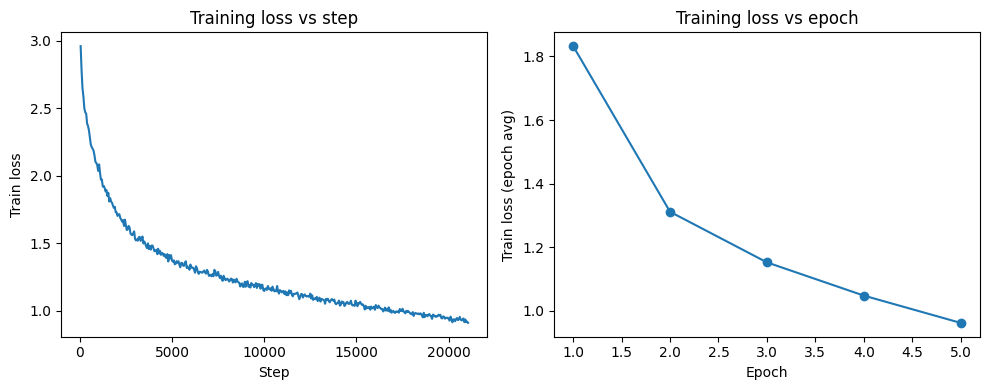

In [34]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

LOG_DIR = "./logs_snellius/gpt-mini/version_0"
EVENT_FILE = [f for f in os.listdir(LOG_DIR) if "tfevents" in f][0]
EVENT_PATH = os.path.join(LOG_DIR, EVENT_FILE)

ea = event_accumulator.EventAccumulator(EVENT_PATH)
ea.Reload()

# 1) Loss per step
step_events = ea.Scalars("train_loss_step")
step_steps  = [e.step for e in step_events]
step_loss   = [e.value for e in step_events]

# 2) Loss per epoch
epoch_events = ea.Scalars("train_loss_epoch")
epoch_idx    = list(range(1, len(epoch_events)+1))      # epochs 1..5
epoch_loss   = [e.value for e in epoch_events]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(step_steps, step_loss)
plt.xlabel("Step")
plt.ylabel("Train loss")
plt.title("Training loss vs step")

plt.subplot(1,2,2)
plt.plot(epoch_idx, epoch_loss, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train loss (epoch avg)")
plt.title("Training loss vs epoch")

plt.tight_layout()
plt.savefig("gpt_grimm_loss_curves.png")
plt.show()


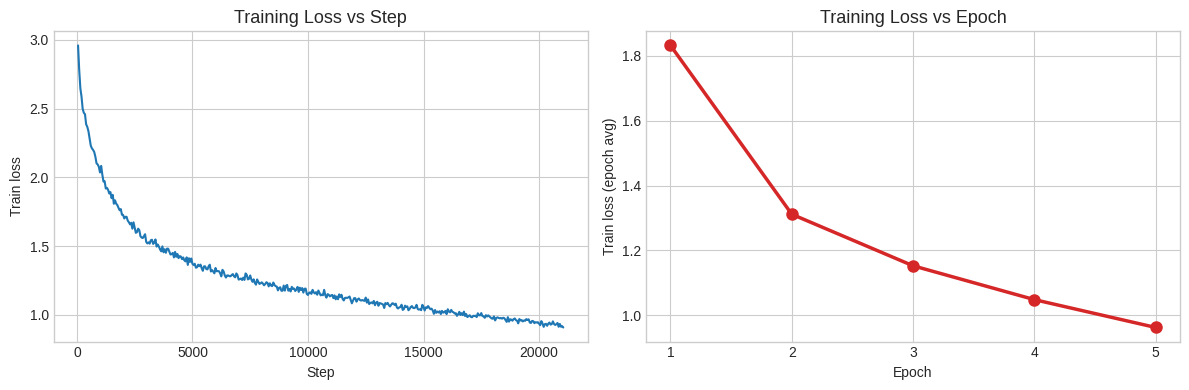

In [35]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(12,4))

# --- Left: Loss vs Step ---
ax[0].plot(step_steps, step_loss, color="#1f77b4", linewidth=1.5)
ax[0].set_title("Training Loss vs Step", fontsize=13)
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Train loss")

# --- Right: Loss vs Epoch ---
ax[1].plot(
    epoch_idx, epoch_loss,
    color="#d62728", linewidth=2.5, marker="o", markersize=8
)
ax[1].set_title("Training Loss vs Epoch", fontsize=13)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Train loss (epoch avg)")
ax[1].set_xticks(epoch_idx)

plt.tight_layout()
plt.savefig("gpt_grimm_loss_curves.png", dpi=150)
plt.show()


In [36]:
# Colab-friendly CNN experiment for Net1/Net2 + conv_types
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

# ----------------------------------------------------------------------
# Reproducibility
# ----------------------------------------------------------------------
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------------------------------------------------
# Dataset generation (from utils.py)
# ----------------------------------------------------------------------
def gen_box_data(trainset, y_train, length=1000, image_size=32, box_size=4,
                 offset1=7, offset2=23, shiftdiv=6):

    np.random.seed(42)
    img = np.zeros([3, image_size, image_size], dtype=float)
    patch = np.ones([box_size, box_size], dtype=float)
    off_size = image_size - box_size

    for i in range(length):

        if i % 2 == 0:
            im = img.copy()
            offsetx = np.random.randint(off_size/2 - box_size)
            offsety = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset1
            # obj 1
            im[0, offsety:offsety+box_size, offsetx:offsetx+box_size] = patch
            # obj 2
            offsetx2 = np.random.randint(offsetx, off_size)
            offsety2 = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset1

            while ((abs(offsetx-offsetx2) < box_size+1)):
                offsetx2 = np.random.randint(offsetx, off_size)
                offsety2 = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset1

            im[1, offsety2:offsety2+box_size, offsetx2:offsetx2+box_size] = patch

            trainset[i] = im
            y_train[i] = 0

        elif i % 2 == 1:
            im = img.copy()
            offsetx = np.random.randint(off_size/2 - box_size)
            offsety = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset2
            # obj 1
            im[1, offsety:offsety+box_size, offsetx:offsetx+box_size] = patch
            # obj 2
            offsetx2 = np.random.randint(offsetx, off_size)
            offsety2 = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset2

            while ((abs(offsetx-offsetx2) < box_size+1)):
                offsetx2 = np.random.randint(offsetx, off_size)
                offsety2 = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset2

            im[0, offsety2:offsety2+box_size, offsetx2:offsetx2+box_size] = patch

            trainset[i] = im
            y_train[i] = 1

    return trainset, y_train

def gen_box_data_test(testset1, y_test1, testset2, y_test2, length=1000,
                      image_size=32, box_size=4, offset1=7, offset2=23,
                      shiftdiv=6):

    np.random.seed(42)
    img = np.zeros([3, image_size, image_size], dtype=float)
    patch = np.ones([box_size, box_size], dtype=float)
    off_size = image_size - box_size

    for i in range(length):

        if i % 2 == 0:
            im = img.copy()
            img2 = img.copy()
            offsetx = np.random.randint(off_size/2 - box_size)
            offsety = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset1
            # obj 1
            im[0, offsety:offsety+box_size, offsetx:offsetx+box_size] = patch
            offsety += 16
            img2[0, offsety:offsety+box_size, offsetx:offsetx+box_size] = patch
            # obj 2
            offsetx2 = np.random.randint(offsetx, off_size)
            offsety2 = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset1

            while ((abs(offsetx-offsetx2) < box_size+1)):
                offsetx2 = np.random.randint(offsetx, off_size)
                offsety2 = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset1

            im[1, offsety2:offsety2+box_size, offsetx2:offsetx2+box_size] = patch
            offsety2 += 16
            img2[1, offsety2:offsety2+box_size, offsetx2:offsetx2+box_size] = patch

            testset1[i] = im
            y_test1[i] = 0
            testset2[i] = img2
            y_test2[i] = 0

        elif i % 2 == 1:
            im = img.copy()
            img2 = img.copy()
            offsetx = np.random.randint(off_size/2 - box_size)
            offsety = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset2
            # obj 1
            im[1, offsety:offsety+box_size, offsetx:offsetx+box_size] = patch
            offsety -= 16
            img2[1, offsety:offsety+box_size, offsetx:offsetx+box_size] = patch
            # obj 2
            offsetx2 = np.random.randint(offsetx, off_size)
            offsety2 = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset2

            while ((abs(offsetx-offsetx2) < box_size+1)):
                offsetx2 = np.random.randint(offsetx, off_size)
                offsety2 = np.random.randint(-off_size/shiftdiv, off_size/shiftdiv) + offset2

            im[0, offsety2:offsety2+box_size, offsetx2:offsetx2+box_size] = patch
            offsety2 -= 16
            img2[0, offsety2:offsety2+box_size, offsetx2:offsetx2+box_size] = patch

            testset1[i] = im
            y_test1[i] = 1
            testset2[i] = img2
            y_test2[i] = 1

    return testset1, y_test1, testset2, y_test2

# ----------------------------------------------------------------------
# Network definition
# ----------------------------------------------------------------------
class Net(nn.Module):
    def __init__(self, conv_type, net_type):
        super(Net, self).__init__()
        self.net_type = net_type
        if conv_type == 'fconv':
            pad_type = 'zeros'
            padding_size = 2
            fc2_inp_dim = 64 * 6 * 6

        elif conv_type == 'sconv':
            pad_type = 'zeros'
            padding_size = 1
            fc2_inp_dim = 64 * 4 * 4

        elif conv_type == 'circular':
            pad_type = 'circular'
            padding_size = 2
            fc2_inp_dim = 64 * 6 * 6

        elif conv_type == 'reflect':
            pad_type = 'reflect'
            padding_size = 2
            fc2_inp_dim = 64 * 6 * 6

        elif conv_type == 'replicate':
            pad_type = 'replicate'
            padding_size = 2
            fc2_inp_dim = 64 * 6 * 6

        elif conv_type == 'valid':
            pad_type = 'zeros'
            padding_size = 0
            fc2_inp_dim = 64 * 2 * 2

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1,
                               padding=padding_size, bias=False,
                               padding_mode=pad_type)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2,
                               padding=padding_size, bias=False,
                               padding_mode=pad_type)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2,
                               padding=padding_size, bias=False,
                               padding_mode=pad_type)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2,
                               padding=padding_size, bias=False,
                               padding_mode=pad_type)
        self.fc1 = nn.Linear(64 * 1 * 1, 2)
        if self.net_type == 'Net1':
            self.adap_max = nn.AdaptiveMaxPool2d(1)
        elif self.net_type == 'Net2':
            self.fc2 = nn.Linear(fc2_inp_dim, 64 * 1 * 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        if self.net_type == 'Net1':
            x = self.adap_max(x)
        elif self.net_type == 'Net2':
            x = torch.flatten(x, start_dim=1)
            x = self.fc2(x)
        else:
            raise NotImplementedError
        x = x.view(-1, 64 * 1 * 1)
        x = self.fc1(x)
        return x

# ----------------------------------------------------------------------
# One experiment: given net_type + conv_type -> mean/std val & test
# ----------------------------------------------------------------------
def run_experiment(net_type='Net2', conv_type='valid',
                   train_size=2000, val_size=1000, test_size=1000,
                   image_size=32, offset1=7, offset2=23, fluctuation=6,
                   n_repeat=10, epochs=50, batch_size=200):

    # --------- data generation ----------
    trainset = np.zeros([train_size, 3, image_size, image_size], dtype=float)
    y_train = np.zeros(train_size)
    valset = np.zeros([val_size, 3, image_size, image_size], dtype=float)
    y_val = np.zeros(val_size)
    testset = np.zeros([test_size, 3, image_size, image_size], dtype=float)
    y_test = np.zeros(test_size)

    trainset, y_train = gen_box_data(trainset, y_train,
                                     length=train_size, image_size=image_size,
                                     offset1=offset1, offset2=offset2,
                                     shiftdiv=fluctuation)
    valset, y_val = gen_box_data(valset, y_val,
                                 length=val_size, image_size=image_size,
                                 offset1=offset1, offset2=offset2,
                                 shiftdiv=fluctuation)

    testset1, y_test1, testset2, y_test2 = gen_box_data_test(
        testset, y_test,
        testset.copy(), y_test.copy(),
        length=test_size,
        image_size=image_size,
        offset1=offset1, offset2=offset2,
        shiftdiv=fluctuation)

    # to torch
    train_set = torch.from_numpy(trainset)
    ytrain = torch.from_numpy(y_train)

    val_set = torch.from_numpy(valset)
    yval = torch.from_numpy(y_val)

    test_set1 = torch.from_numpy(testset1)
    ytest1 = torch.from_numpy(y_test1)

    test_set2 = torch.from_numpy(testset2)
    ytest2 = torch.from_numpy(y_test2)

    # dataloaders
    trainloader = DataLoader(TensorDataset(train_set, ytrain),
                             batch_size=batch_size, shuffle=True)
    valloader = DataLoader(TensorDataset(val_set, yval),
                           batch_size=batch_size, shuffle=False)
    testloader_diss = DataLoader(TensorDataset(test_set2, ytest2),
                                 batch_size=batch_size, shuffle=False)

    results_val = {}
    results_test = {}

    criterion_class = nn.CrossEntropyLoss()

    for m in range(n_repeat):
        print(f"=== {net_type}, {conv_type}, run {m+1}/{n_repeat} ===")
        torch.manual_seed(m)
        net = Net(conv_type=conv_type, net_type=net_type).to(device)

        optimizer = optim.Adadelta([{'params': net.parameters()}], lr=1.0,
                                   rho=0.9, eps=1e-06, weight_decay=0.00005)

        best_val_loss = float("inf")
        patience = 0
        max_patience = 8
        best_state_dict = None

        # ------- training -------
        for epoch in range(epochs):
            if patience > max_patience:
                break

            net.train()
            train_loss = 0.0
            correct_train = 0.0
            total_train = 0.0

            for images, labels in trainloader:
                images = images.float().to(device)
                labels = labels.long().to(device)

                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion_class(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            epoch_loss = train_loss / len(trainloader)
            epoch_acc = correct_train / total_train
            print(f"Epoch {epoch+1}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")

            # ------- validation -------
            net.eval()
            val_loss = 0.0
            correct_val = 0.0
            total_val = 0.0
            with torch.no_grad():
                for images, labels in valloader:
                    images = images.float().to(device)
                    labels = labels.long().to(device)
                    outputs = net(images)
                    loss = criterion_class(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss /= total_val
            val_acc = 100.0 * correct_val / total_val
            print(f"  val_loss={val_loss:.6f}, val_acc={val_acc:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state_dict = net.state_dict()
                patience = 0
            else:
                patience += 1

        # ------- testing with best model -------
        net.load_state_dict(best_state_dict)
        net.eval()
        testing_loss = 0.0
        correct_test = 0.0
        total_test = 0.0

        with torch.no_grad():
            for images, labels in testloader_diss:
                images = images.float().to(device)
                labels = labels.long().to(device)
                outputs = net(images)
                loss = criterion_class(outputs, labels)
                testing_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        testing_loss /= total_test
        test_acc = 100.0 * correct_test / total_test
        print(f"Test loss={testing_loss:.6f}, test_acc={test_acc:.2f}%")

        results_val[m] = val_acc
        results_test[m] = test_acc

    acc_val = np.array([results_val[i] for i in range(n_repeat)])
    acc_test = np.array([results_test[i] for i in range(n_repeat)])

    mean_val, std_val = acc_val.mean(), acc_val.std()
    mean_test, std_test = acc_test.mean(), acc_test.std()

    print("*******************************************")
    print(" Type of convolution : ", conv_type)
    print(" Type of network     : ", net_type)
    print("*******************************************")
    print('Results for validation dataset', results_val)
    print('mean: {:.4f} std: {:.4f} for validation'.format(mean_val, std_val))
    print('Results for test dataset', results_test)
    print('mean: {:.4f} std: {:.4f} for test'.format(mean_test, std_test))

    return mean_val, std_val, mean_test, std_test

# ----------------------------------------------------------------------
# Run all conv_types for Net2 and print LaTeX table
# ----------------------------------------------------------------------
conv_types = ["valid", "replicate", "reflect", "circular", "sconv", "fconv"]

results = {}
for ct in conv_types:
    mv, sv, mt, st = run_experiment(net_type="Net2", conv_type=ct)
    results[ct] = (mv, sv, mt, st)

print("\n\nLaTeX table for Net2:\n")
print(r"\begin{table}[h]")
print(r"\centering")
print(r"\begin{tabular}{lcc}")
print(r"\hline")
print(r"\textbf{conv\_type} & \textbf{Validation acc. (mean $\pm$ std)} & \textbf{Test acc. (mean $\pm$ std)} \\")
print(r"\hline")
for ct in conv_types:
    mv, sv, mt, st = results[ct]
    print(f"{ct} & ${mv:.2f} \\pm {sv:.2f}$ & ${mt:.2f} \\pm {st:.2f}$ \\\\")
print(r"\hline")
print(r"\end{tabular}")
print(r"\caption{Validation and test accuracy of Net2 for different convolution types.}")
print(r"\end{table}")


Streaming output truncated to the last 5000 lines.
  val_loss=0.000000, val_acc=100.00%
Epoch 30: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 31: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 32: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 33: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 34: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 35: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 36: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 37: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 38: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 39: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 40: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 41: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_acc=100.00%
Epoch 42: loss=0.0000, acc=1.0000
  val_loss=0.000000, val_a

Using: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


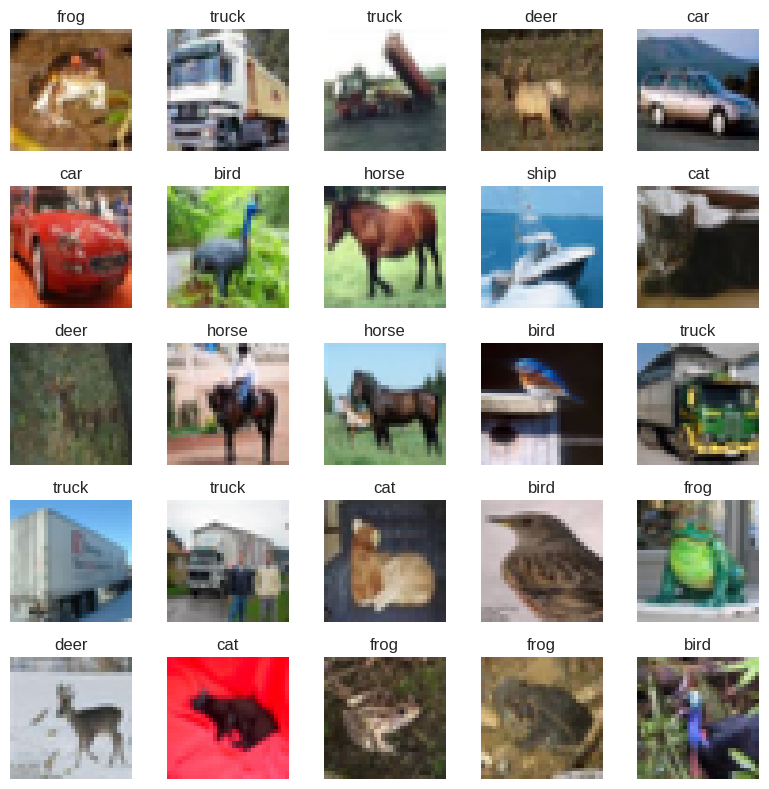


Training original model (NO augmentation)…


100%|██████████| 782/782 [00:08<00:00, 89.28it/s]


Epoch 1 Loss: 1.5779


100%|██████████| 782/782 [00:08<00:00, 90.87it/s]


Epoch 2 Loss: 1.2085


100%|██████████| 782/782 [00:08<00:00, 90.65it/s]


Epoch 3 Loss: 1.0326


100%|██████████| 782/782 [00:08<00:00, 91.92it/s]


Epoch 4 Loss: 0.9233


100%|██████████| 782/782 [00:08<00:00, 92.21it/s]


Epoch 5 Loss: 0.8561


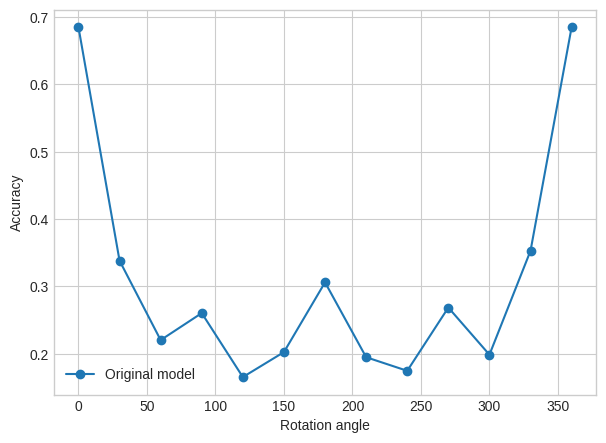


Training model WITH rotational augmentation…


100%|██████████| 782/782 [00:13<00:00, 58.93it/s]


Epoch 1 Loss: 1.9378


100%|██████████| 782/782 [00:13<00:00, 58.58it/s]


Epoch 2 Loss: 1.6796


100%|██████████| 782/782 [00:13<00:00, 58.77it/s]


Epoch 3 Loss: 1.5883


100%|██████████| 782/782 [00:13<00:00, 58.72it/s]


Epoch 4 Loss: 1.5337


100%|██████████| 782/782 [00:13<00:00, 58.92it/s]


Epoch 5 Loss: 1.5007


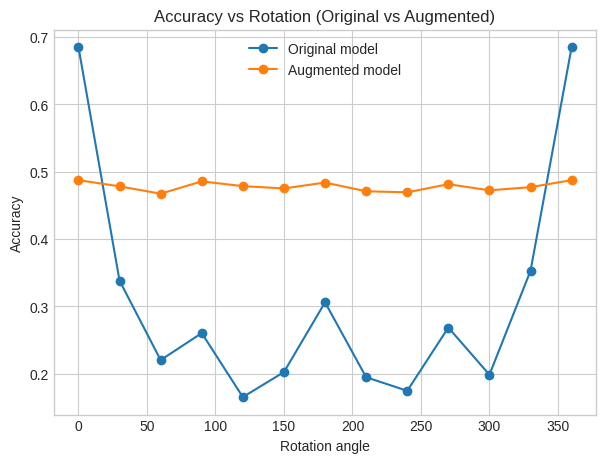

In [37]:
# ========================================
# 1) IMPORTS
# ========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# ========================================
# 2) LOAD CIFAR-10 (NO AUGMENTATION)
# ========================================
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=64, shuffle=False)

# ========================================
# 3) DISPLAY FIRST 25 IMAGES
# ========================================
def display_first_few_images(data):
    class_names = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]
    plt.figure(figsize=(8,8))
    for i in range(25):
        img, label = data[i]
        img_np = img.permute(1,2,0).numpy()
        plt.subplot(5,5,i+1)
        plt.imshow(img_np)
        plt.title(class_names[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_first_few_images(train_data)

# ========================================
# 4) CNN MODEL
# ========================================
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc1   = nn.Linear(64*4*4, 64)
        self.fc2   = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64*4*4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ========================================
# 5) TRAIN FUNCTION
# ========================================
def train(model, loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {running_loss/len(loader):.4f}")

# ========================================
# 6) INFERENCE FUNCTION
# ========================================
def inference(model, images):
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    return preds

# ========================================
# 7) ACCURACY VS ROTATION ANGLE
# ========================================
def get_acc_per_angle(model):
    model.eval()
    angles = [0,30,60,90,120,150,180,210,240,270,300,330,360]
    accs = []

    with torch.no_grad():
        for angle in angles:
            rot_tf = transforms.Compose([
                transforms.RandomRotation((angle, angle)),
                transforms.ToTensor()
            ])

            rotated_test = datasets.CIFAR10(
                root='./data', train=False, download=False, transform=rot_tf
            )

            rotated_loader = torch.utils.data.DataLoader(
                rotated_test, batch_size=64, shuffle=False
            )

            correct = 0
            total = 0
            for imgs, labels in rotated_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                preds = inference(model, imgs)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            accs.append(correct / total)

    return angles, accs

# ========================================
# 8) PLOT FUNCTION
# ========================================
def plot_curve(angles, accs, label):
    plt.plot(angles, accs, marker='o', label=label)

# ========================================
# 9) TRAIN ORIGINAL MODEL + PLOT
# ========================================
model = CNN().to(device)
print("\nTraining original model (NO augmentation)…")
train(model, train_loader, epochs=5)

angles_orig, accs_orig = get_acc_per_angle(model)

plt.figure(figsize=(7,5))
plot_curve(angles_orig, accs_orig, "Original model")
plt.xlabel("Rotation angle")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# ========================================
# 10) TRAIN MODEL WITH ROTATION AUGMENTATION
# ========================================
augment_tf = transforms.Compose([
    transforms.RandomRotation(360),
    transforms.ToTensor()
])

train_aug = datasets.CIFAR10(root='./data', train=True, download=True, transform=augment_tf)
train_aug_loader = torch.utils.data.DataLoader(train_aug, batch_size=64, shuffle=True)

model_aug = CNN().to(device)
print("\nTraining model WITH rotational augmentation…")
train(model_aug, train_aug_loader, epochs=5)

angles_aug, accs_aug = get_acc_per_angle(model_aug)

# ========================================
# 11) FINAL COMPARISON PLOT
# ========================================
plt.figure(figsize=(7,5))
plot_curve(angles_orig, accs_orig, "Original model")
plot_curve(angles_aug, accs_aug, "Augmented model")
plt.xlabel("Rotation angle")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.title("Accuracy vs Rotation (Original vs Augmented)")
plt.show()
